<a href="https://colab.research.google.com/github/Manya123-max/Assesments/blob/main/Ticket_Classification_and_Entity_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time NLP/ML Pipeline for Ticket Classification and Entity Extraction

In [47]:
!pip install matplotlib seaborn spacy textblob imbalanced-learn xgboost gradio joblib
!python -m spacy download en_core_web_sm
!python -m nltk.downloader stopwords punkt wordnet punkt_tab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab t

In [60]:
# Real-Time NLP/ML Pipeline for Ticket Classification and Entity Extraction

import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
import gradio as gr
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [61]:
nlp = spacy.load("en_core_web_sm")

df = pd.read_csv("/content/ai_dev_assignment_tickets_complex_1000.csv")
print("Raw data loaded. First 5 rows:")
print(df.head())

Raw data loaded. First 5 rows:
   ticket_id                                        ticket_text  \
0          1  Payment issue for my SmartWatch V2. I was unde...   
1          2  Can you tell me more about the UltraClean Vacu...   
2          3  I ordered SoundWave 300 but got EcoBreeze AC i...   
3          4  Facing installation issue with PhotoSnap Cam. ...   
4          5  Order #30903 for Vision LED TV is 13 days late...   

           issue_type urgency_level            product  
0     Billing Problem        Medium      SmartWatch V2  
1     General Inquiry           NaN  UltraClean Vacuum  
2          Wrong Item        Medium      SoundWave 300  
3  Installation Issue           Low      PhotoSnap Cam  
4       Late Delivery           NaN      Vision LED TV  


1. Data Loading and Preprocessing

In [62]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

def clean_data(df):
    df = df.dropna().copy()
    df.loc[:, 'clean_text'] = df['ticket_text'].apply(preprocess_text)
    df.loc[:, 'ticket_length'] = df['ticket_text'].apply(lambda x: len(x))
    df.loc[:, 'sentiment'] = df['ticket_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    return df

df = clean_data(df)
print("\nAfter cleaning - First 5 rows:")
print(df.head())


After cleaning - First 5 rows:
   ticket_id                                        ticket_text  \
0          1  Payment issue for my SmartWatch V2. I was unde...   
2          3  I ordered SoundWave 300 but got EcoBreeze AC i...   
3          4  Facing installation issue with PhotoSnap Cam. ...   
5          6  Can you tell me more about the PhotoSnap Cam w...   
6          7   is malfunction. It stopped working after just...   

           issue_type urgency_level        product  \
0     Billing Problem        Medium  SmartWatch V2   
2          Wrong Item        Medium  SoundWave 300   
3  Installation Issue           Low  PhotoSnap Cam   
5     General Inquiry        Medium  PhotoSnap Cam   
6      Product Defect           Low   EcoBreeze AC   

                                          clean_text  ticket_length  sentiment  
0  payment issue smartwatch v2 underbilled order ...             71        0.0  
2  ordered soundwave 300 got ecobreeze ac instead...             80        0.0

 2. Feature Engineering

In [63]:
def extract_features(df):
    tfidf = TfidfVectorizer(max_features=1000)
    X_tfidf = tfidf.fit_transform(df['clean_text'])
    X_other = df[['ticket_length', 'sentiment']].values
    return hstack([X_tfidf, X_other]), tfidf

X, tfidf = extract_features(df)
print("Feature matrix shape:", X.shape)

Feature matrix shape: (826, 455)


3. Multi-Task Learning (Classical ML)

In [64]:
def train_models(X, df):
    le_issue = LabelEncoder()
    y_issue = le_issue.fit_transform(df['issue_type'])
    le_urgency = LabelEncoder()
    y_urgency = le_urgency.fit_transform(df['urgency_level'])

    smote = SMOTE(random_state=42)
    X_issue_resampled, y_issue_resampled = smote.fit_resample(X, y_issue)
    X_urgency_resampled, y_urgency_resampled = smote.fit_resample(X, y_urgency)

    X_train_issue, X_test_issue, y_issue_train, y_issue_test = train_test_split(
        X_issue_resampled, y_issue_resampled, test_size=0.2, random_state=42
    )
    X_train_urgency, X_test_urgency, y_urgency_train, y_urgency_test = train_test_split(
        X_urgency_resampled, y_urgency_resampled, test_size=0.2, random_state=42
    )

    clf_issue = XGBClassifier(eval_metric='mlogloss', random_state=42)
    clf_issue.fit(X_train_issue, y_issue_train)

    clf_urgency = XGBClassifier(eval_metric='mlogloss', random_state=42)
    clf_urgency.fit(X_train_urgency, y_urgency_train)

    print("\nIssue Type Classification Report:")
    print(classification_report(y_issue_test, clf_issue.predict(X_test_issue)))
    print("\nUrgency Level Classification Report:")
    print(classification_report(y_urgency_test, clf_urgency.predict(X_test_urgency)))

    joblib.dump(clf_issue, "clf_issue.pkl")
    joblib.dump(clf_urgency, "clf_urgency.pkl")
    joblib.dump(le_issue, "le_issue.pkl")
    joblib.dump(le_urgency, "le_urgency.pkl")
    joblib.dump(tfidf, "tfidf.pkl")

    return clf_issue, clf_urgency, le_issue, le_urgency

clf_issue, clf_urgency, le_issue, le_urgency = train_models(X, df)
print("Models trained and saved successfully!")


Issue Type Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        33
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        29
           6       1.00      1.00      1.00        27

    accuracy                           1.00       187
   macro avg       1.00      1.00      1.00       187
weighted avg       1.00      1.00      1.00       187


Urgency Level Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.51      0.48        61
           1       0.41      0.29      0.34        56
           2       0.35      0.41      0.38        56

    accuracy                           0.40       173
   macro avg       0.40      0.40      0.40       173
weig

4. Entity Extraction (Rule-based)

In [65]:
'''def extract_entities(text, df):
    entities = {}
    doc = nlp(text)
    entities['dates'] = [ent.text for ent in doc.ents if ent.label_ == 'DATE']
    all_products = set(df['product'].dropna().str.lower().unique())
    all_complaints = set(df['issue_type'].dropna().str.lower().unique())
    entities['products'] = [kw for kw in all_products if kw in text.lower()]
    entities['complaints'] = [kw for kw in all_complaints if kw in text.lower()]
    return entities'''

def extract_entities(text, df):
    doc = nlp(text)
    dates = [ent.text for ent in doc.ents if ent.label_ == 'DATE']
    all_products = set(df['product'].dropna().str.lower().unique())
    all_complaints = set(df['issue_type'].dropna().str.lower().unique())
    text_lower = text.lower()
    products = [prod for prod in all_products if prod in text_lower]
    complaints = [comp for comp in all_complaints if comp in text_lower]
    return {
        "dates": dates,
        "products": products,
        "complaints": complaints
    }

 5. Integration Function

In [66]:
def analyze_ticket(text, clf_issue, clf_urgency, tfidf, le_issue, le_urgency, df):
    cleaned = preprocess_text(text)
    features = tfidf.transform([cleaned])
    extra = np.array([[len(text), TextBlob(text).sentiment.polarity]])
    X = hstack([features, extra])

    issue_pred = clf_issue.predict(X)
    urgency_pred = clf_urgency.predict(X)
    entities = extract_entities(text, df)

    return {
        "Predicted Issue Type": le_issue.inverse_transform(issue_pred)[0],
        "Predicted Urgency Level": le_urgency.inverse_transform(urgency_pred)[0],
        "Extracted Entities": entities
    }

def batch_analyze(text_block):
    results = []
    for line in text_block.strip().split("\n"):
        if line.strip():
            result = analyze_ticket(line.strip(), clf_issue, clf_urgency, tfidf, le_issue, le_urgency, df)
            results.append({
                "ticket": line.strip(),
                "issue": result["Predicted Issue Type"],
                "urgency": result["Predicted Urgency Level"],
                "entities": result["Extracted Entities"]
            })
    return results

# Test with a sample ticket
print("\nTesting with sample ticket...")
sample_text = df.iloc[0]['ticket_text']
print("Sample Ticket Text:", sample_text)
result = analyze_ticket(sample_text, clf_issue, clf_urgency, tfidf, le_issue, le_urgency, df)
print("Analysis Result:", result)


Testing with sample ticket...
Sample Ticket Text: Payment issue for my SmartWatch V2. I was underbilled for order #29224.
Analysis Result: {'Predicted Issue Type': 'Billing Problem', 'Predicted Urgency Level': 'Medium', 'Extracted Entities': {'dates': [], 'products': ['smartwatch v2'], 'complaints': []}}


6. Gradio Interface

In [67]:
'''def gradio_interface(text):
    result = analyze_ticket(text, clf_issue, clf_urgency, tfidf, le_issue, le_urgency, df)
    return result["Predicted Issue Type"], result["Predicted Urgency Level"], result["Extracted Entities"]'''

def gradio_interface(text):
    result = analyze_ticket(text, clf_issue, clf_urgency, tfidf, le_issue, le_urgency, df)
    issue = result["Predicted Issue Type"]
    urgency = result["Predicted Urgency Level"]
    entities = result["Extracted Entities"]
    return issue, urgency, entities

with gr.Blocks() as demo:
    gr.Markdown("Ticket Classifier with Entity Extraction")

    with gr.Tab("Single Ticket"):
        input_box = gr.Textbox(lines=4, label="Enter Ticket Text")
        output_issue = gr.Textbox(label="Predicted Issue Type")
        output_urgency = gr.Textbox(label="Predicted Urgency Level")
        output_entities = gr.JSON(label="Extracted Entities")
        btn_single = gr.Button("Analyze")
        btn_single.click(fn=gradio_interface, inputs=input_box,
                       outputs=[output_issue, output_urgency, output_entities])

    with gr.Tab("Batch Tickets"):
        batch_input = gr.Textbox(lines=10, label="Enter one ticket per line")
        batch_output = gr.JSON(label="Results")
        btn_batch = gr.Button("Analyze All")
        btn_batch.click(fn=batch_analyze, inputs=batch_input, outputs=batch_output)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7d562d253b7cf8b6e7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


 Visualization Tools

Class Distribution Visualization

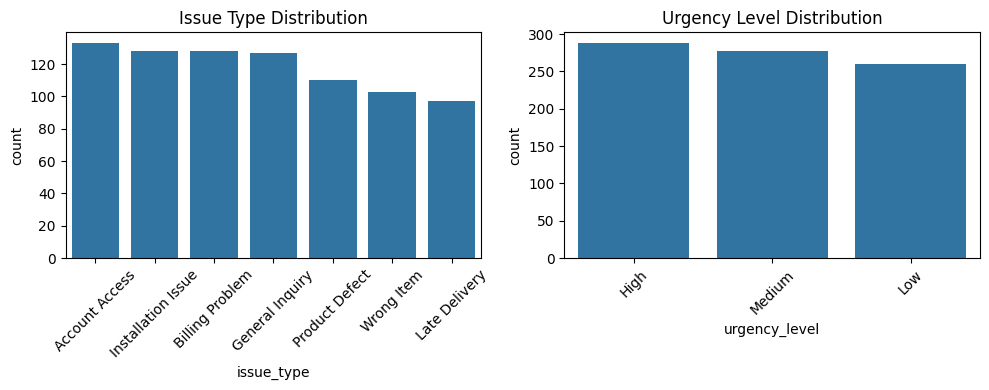

In [56]:
def visualize_class_distribution(df):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.countplot(x='issue_type', data=df, order=df['issue_type'].value_counts().index)
    plt.title("Issue Type Distribution")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x='urgency_level', data=df, order=df['urgency_level'].value_counts().index)
    plt.title("Urgency Level Distribution")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Call the function
visualize_class_distribution(df)


Confusion Matrices for Model Evaluation

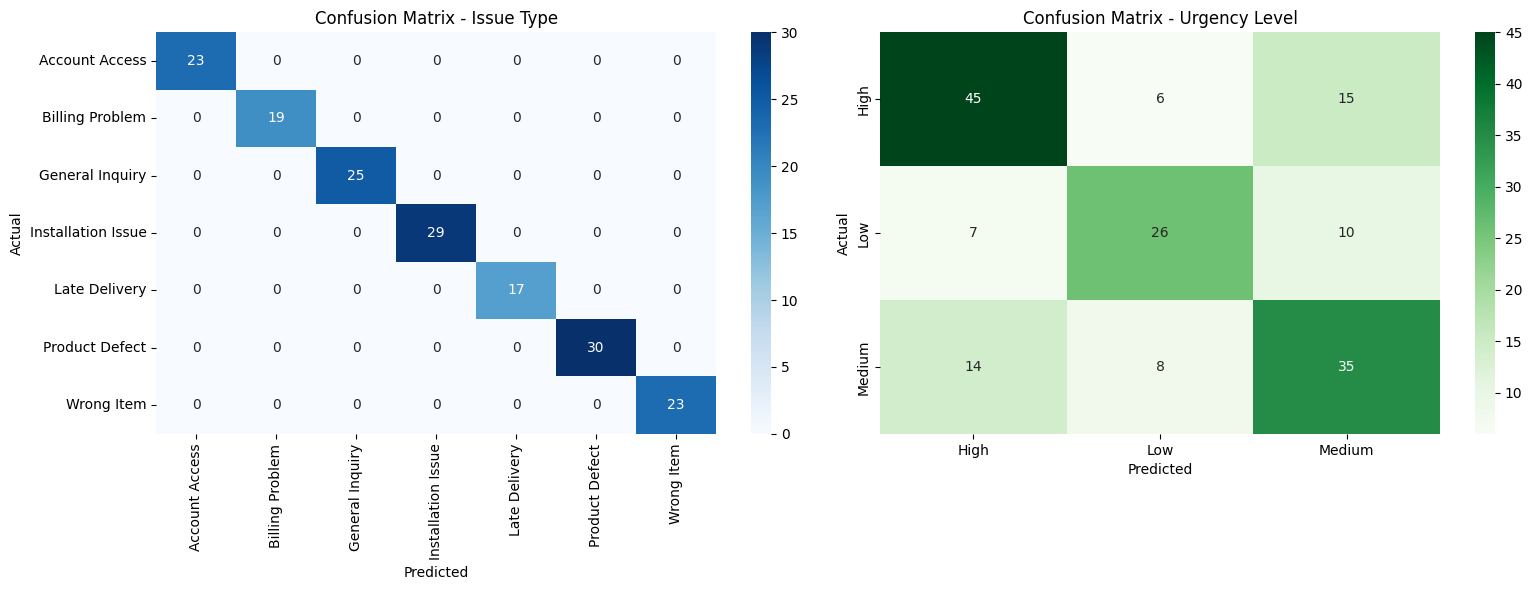

In [57]:
def plot_confusion_matrices(y_true_issue, y_pred_issue, y_true_urgency, y_pred_urgency, le_issue, le_urgency):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    cm_issue = confusion_matrix(y_true_issue, y_pred_issue)
    sns.heatmap(cm_issue, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_issue.classes_, yticklabels=le_issue.classes_, ax=axes[0])
    axes[0].set_title("Confusion Matrix - Issue Type")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    cm_urgency = confusion_matrix(y_true_urgency, y_pred_urgency)
    sns.heatmap(cm_urgency, annot=True, fmt='d', cmap='Greens',
                xticklabels=le_urgency.classes_, yticklabels=le_urgency.classes_, ax=axes[1])
    axes[1].set_title("Confusion Matrix - Urgency Level")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

X_train_issue, X_test_issue, y_train_issue, y_test_issue = train_test_split(X, le_issue.transform(df['issue_type']), test_size=0.2, random_state=42)
X_train_urgency, X_test_urgency, y_train_urgency, y_test_urgency = train_test_split(X, le_urgency.transform(df['urgency_level']), test_size=0.2, random_state=42)

y_pred_issue = clf_issue.predict(X_test_issue)
y_pred_urgency = clf_urgency.predict(X_test_urgency)


plot_confusion_matrices(y_test_issue, y_pred_issue, y_test_urgency, y_pred_urgency, le_issue, le_urgency)


Feature Importance Plot

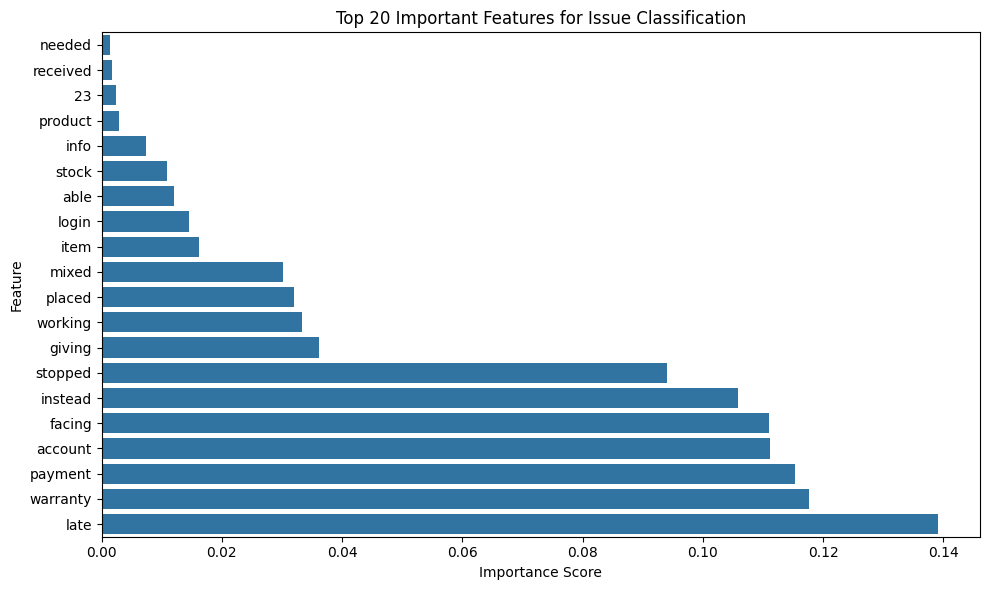

In [58]:
def plot_feature_importance(model, tfidf):
    feature_names = tfidf.get_feature_names_out().tolist() + ['ticket_length', 'sentiment']
    importance = model.feature_importances_

    top_idx = np.argsort(importance)[-20:]
    top_features = [feature_names[i] for i in top_idx]
    top_importance = importance[top_idx]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_importance, y=top_features)
    plt.title("Top 20 Important Features for Issue Classification")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


plot_feature_importance(clf_issue, tfidf)

Visualize TF-IDF features using TSNE

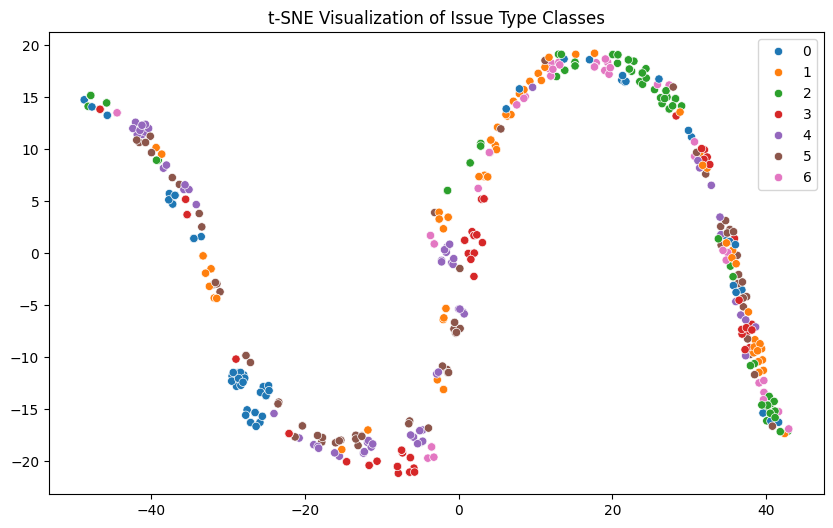

In [59]:
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix

def plot_tsne(X, labels, title):
    # Convert to CSR format for efficient row slicing
    X_csr = csr_matrix(X)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    # Slice the first 500 rows from the CSR matrix
    X_2d = tsne.fit_transform(X_csr[:500].toarray())  # Use first 500 for speed

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels[:500], palette='tab10', legend='full')
    plt.title(title)
    plt.show()

plot_tsne(X, le_issue.transform(df['issue_type']), "t-SNE Visualization of Issue Type Classes")